In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
using Statistics
using QuadGK
using ForwardDiff
using TaylorSeries
using Printf
using ProgressMeter
using Base.Threads
using BenchmarkTools


# Helper Functions

In [2]:

# ========================================
# Some Helper Functions
# ========================================

function printMsg(msg)
    println("="^40)
    println(msg)
    println("="^40)
end

meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))

meshgrid (generic function with 1 method)

In [3]:
function PEDS_f(dX, X, f, alpha)
    X = X[:, :]
    N, _ = size(X)
    Omega1 = fill(1/N, (N,N))
    first_term = mean(f.([(X[i, :]) for i in 1:N]))
    first_term = reshape(first_term, 1, :)
    second_term = -alpha * (I-Omega1) * X
    
    if !isnothing(dX)
        @. dX = first_term + second_term
    end
    first_term .+ second_term
end




PEDS_f (generic function with 1 method)

In [4]:
function getRandRange(upper, lower, normalized_random_number)
    @. lower + (upper - lower) * normalized_random_number
end

function N_dim_sampler(N, sampler)
    list = typeof(sampler())[]
    for _=1:N
        push!(list, sampler())
    end
    list
end

N_dim_sampler (generic function with 1 method)

In [5]:
# function getRandRange(upper, lower, normalized_random_number)
#     @. lower + (upper - lower) * normalized_random_number
# end
    
# struct UniformSampler
#     generator
#     upper::Float64
#     lower::Float64
#     size::Int
# end

# function Base.iterate(g::UniformSampler)
#     normalized_random_number = rand(Float64, g.dimension)
#     getRandRange(g.upper, g.lower, normalized_random_number), 1
    
#     Vector{typeof(g.generator())}
# end

# function Base.iterate(g::UniformSampler, state::Int64)
#     if state >= g.size
#         return nothing
#     end
    
#     normalized_random_number = rand(Float64, g.dimension)
#     getRandRange(g.upper, g.lower, normalized_random_number), state+1
# end

# function Base.length(g::UniformSampler)
#     count = 0
#     for x in g
#         count += 1
#     end
#     count
# end
    
# unif = UniformSampler((3,2), -2.5, 2.5, 4)
# println(length(unif))
# for i in unif
#     println(i)
# end

In [6]:
IN_SCRIPT = false
if match(r"^In\[[0-9]*\]$", @__FILE__) != nothing
    printMsg("Running in Jupyter")
    IN_SCRIPT = false
else
    printMsg("Running in script")
    IN_SCRIPT = true
    ENV["GKSwstype"]="nul"
end

Running in Jupyter


false

# Scalar function (m=1)

$$
\frac{dX}{dt} = \sum_{i=0}^N \Omega_1 a_i X^i \vec{1} - \alpha (I - \Omega_1) \vec{1}
$$

## Objective function and derivative definition

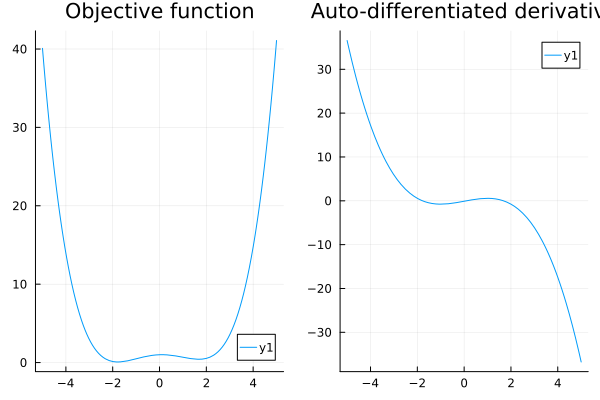

In [7]:
V(x) = (x)^4/12 - 1/2*(x)^2 +1/10 * x + 1
f(x) = -ForwardDiff.derivative.(V, x)

p1 = plot(V, title="Objective function")
p2 = plot(f, title="Auto-differentiated derivative")
plot(p1, p2)

## One dynamic

One particle dynamic
1.6797014356055406


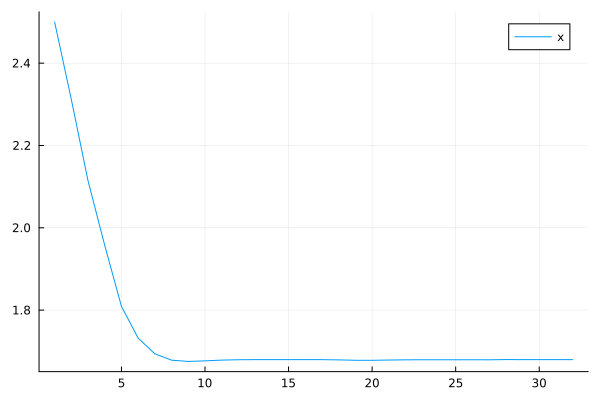

In [8]:
printMsg("One particle dynamic")


tspan = (0, 100)

grad_f = (dX, X, p=0, t=0) -> PEDS_f(dX, X, f, 1)

prob = ODEProblem(grad_f, [3; 2], tspan, 0)
sol = solve(prob)

x = [mean(vec) for vec in sol.u]

println(x[end])
plot(x, label="x")



### Slope field

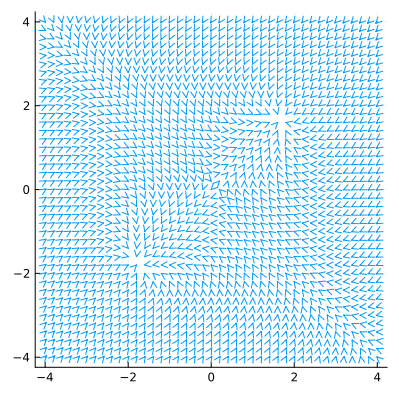

In [9]:

function plot_slope_field(grad_f)
    x, y = meshgrid(-4:0.2:4, -4:0.2:4)

    u, v = [], []
    for (xi, yi) in zip(x, y)
        g = grad_f(nothing, [xi, yi])
        push!(u, g[1])
        push!(v, g[2])
    end

    scale = 0.002
    u .= scale * u
    v .= scale * v
    quiver(x, y, quiver=(u, v))
    plot!(size=(400,400))
end

plot_slope_field(grad_f)

### Initial points

Probability of global convergence: 57.60%


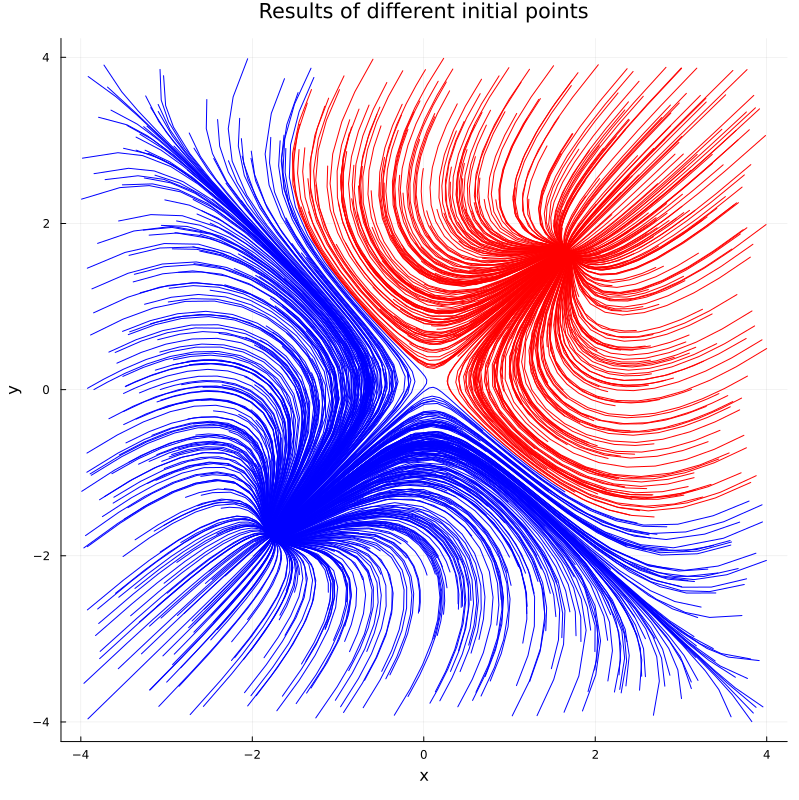

In [10]:
plot()

function sample_initial_points_for_2d(grad_f, lower, upper, sample_size, tspan)

    x, y = meshgrid(-4:0.1:4, -4:0.1:4)
    grid = [[a, b] for (a, b) in zip(x, y)]

    global_count, local_count = 0, 0

    for i in 1:sample_size
        X0 =  lower .+ (upper - lower) .* rand(2)

        prob = ODEProblem(grad_f, X0, tspan)
        sol = solve(prob)

        # Extract x and y values
        x_values = [point[1] for point in sol.u]
        y_values = [point[2] for point in sol.u]

        # Create scatter plot
        if y_values[end] < 0
            color = :blue
            global_count += 1
        else
            color = :red
            local_count += 1
        end

        plot!(x_values, y_values, title="Results of different initial points", 
            xlabel="x", ylabel="y", legend=false, linecolor = color)
    end

    @printf("Probability of global convergence: %.2f%%\n", global_count / (global_count + local_count) * 100)
    # println()

    plot!(size=(800,800))
end

sample_initial_points_for_2d(grad_f, -4, 4, 1e3, tspan)


## Two particles dynamics

In [11]:
printMsg("Two particle dynamic")

Two particle dynamic


In [12]:

X0 = [4;-1.5]
prob = ODEProblem(grad_f, X0, tspan)
sol = solve(prob)
x1 = [i[1] for i in sol.u]
x2 = [i[2] for i in sol.u]

y1 = V.(x1)
y2 = V.(x2)
println()


### Plot animations

In [13]:

function graph_2d_animation(V, grad_f, x1, y1, x2, y2)
    anim = @animate for i in eachindex(x1)
        plot(V, -4, 4, label = "Potential")
        scatter!([x1[i]], [y1[i]], label = "x1")
        p1 = scatter!([x2[i]], [y2[i]], label = "x2")

        plot_slope_field(grad_f)
        # plot(slope_field)
        p2 = scatter!([x1[i]], [x2[i]], label="X")

        plot(p1, p2, layout=(1,2), size = (1200, 600))
    end fps = 2
end

# anim = graph_2d_animation(V, grad_f, x1, y1, x2, y2)
# gif(anim, "dynamic.gif", fps=2)



graph_2d_animation (generic function with 1 method)

## N particle dynamics

In [14]:
printMsg("N particle dynamic")

N particle dynamic


### V, f, and grad_f

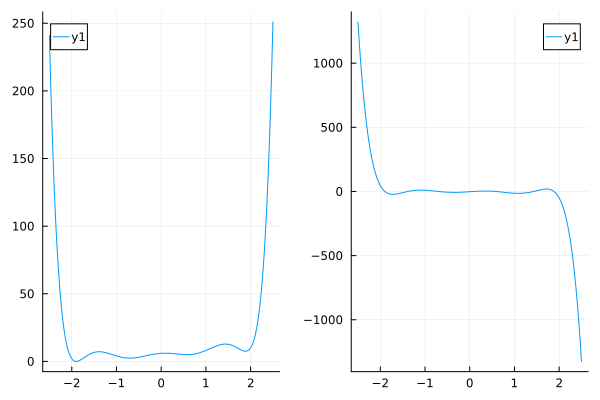

In [15]:
# Declare the function to use

V(x) = x^8 - 8x^6 + 19x^4 - 12x^2 + 2x + 6
f1 = x -> -ForwardDiff.derivative.(V, x) # Is this dot a safe thing to do?
grad_f = (dX, X, p=0, t=0) -> PEDS_f(dX, X, f1, 1) # set alpha to 1

p1 = plot(V, -2.5, 2.5)
p2 = plot(f1, -2.5, 2.5)
plot(p1, p2)


Try to understand the addition of two potential functions here

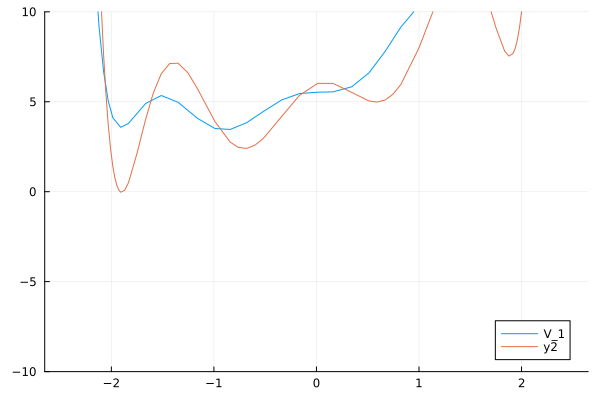

In [16]:
function convolV(V, X, N, step)
    y = V(X)
    for i in 1:N
        y += V(X+step*i)
    end
    y /= (N+1)
end

V_1 = x -> convolV(V, x, 1, 0.5)


plot(V_1, label="V_1", -2.5, 2.5)
plot!(V, -2.5, 2.5)
ylims!(-10,10)

In [17]:
N = 10
Ω₁ = fill(1, (N, N)) / N

X0 = (rand(N) .- 0.5) .* 2 .* 2

prob = ODEProblem(grad_f, X0, tspan)
sol = solve(prob)

# sol = getSolution(X0, (0, 10), p)

println(X0)

[0.8779926992424048, -0.5008017674197309, -0.17817096733909343, 0.7742622318693577, 0.12886401451537433, 0.7535537796555754, 1.3403380629169281, 0.3832290772562055, 1.0001674081252632, -1.4497955299625263]


##### Plot function

Converge to -0.70

[ Info: Saved animation to /Users/charliechen/workspace/am_sure/dynamic.gif


Plots.AnimatedGif("/Users/charliechen/workspace/am_sure/dynamic.gif")
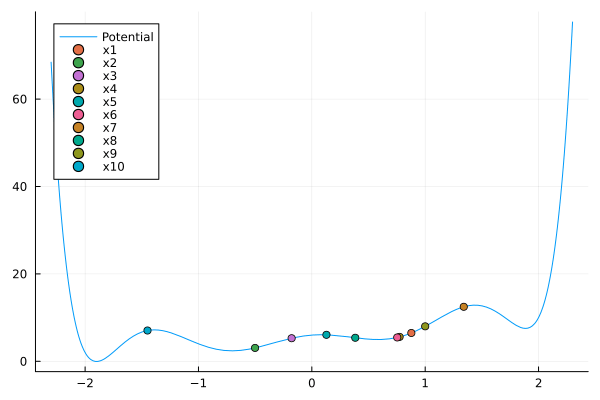

In [18]:
function Plot1D(sol, V)
    lower = -2.3
    upper = 2.3
    plot(V, lower, upper, label = "Potential")
        
    for j in eachindex(sol.u[1])
        xs = [sol.u[i][j] for i in 1:length(sol.u)]
        y = V.(xs)
        scatter!(xs, y, label = "x$j")
    end
    
    plot!()
end
function PlotAnim1D(sol, V_0)
    lower = -2.3
    upper = 2.3
    anim = @animate for i in eachindex(sol.u)
        plot(V_0, lower, upper, label = "Potential")
        
        
        for j in eachindex(sol.u[1])
            x0 = sol.u[1][j]
            y0 = V_0(x0)
            
            x = sol.u[i][j]
            y = V_0(x)
            # scatter!([x0], [y0], label = "x$(j)_0")
            scatter!([x], [y], label = "x$j")
        end
    end fps = 30
    
    anim
end

anim = PlotAnim1D(sol, V)

@printf("Converge to %.2f", mean(sol.u[end]))

gif(anim, "dynamic.gif")

### Experiments for different N

In [19]:
# printMsg("Running grid experiment")

# N_results = Float64[]

# if IN_SCRIPT
#     upper = 8
# else
#     upper = 2
# end

# for N=1:upper
#     X_list_iterator = collect(GridStruct(-2, 2, 0.2, N))
#     println("The total number of sample: ", length(X_list_iterator))
#     push!(N_results, Experiment(grad_f, X_list_iterator, -1.89))
#     println("N_results: ", N_results)
#     flush(stdout)
# end


For the potential function
$$
V(x) = x^8 - 8x^6 + 19x^4 - 12x^2 + 2x + 2
$$

The results (ran on HPC) are 
| Number of Particles (N) | Global Convergence Probability | Grid Size |
|------------------------|-------------------------------|-----------|
| 1                      | 0.19047619047619047          | 0.2       |
| 2                      | 0.30385487528344673          | 0.2       |
| 3                      | 0.3911024727351258           | 0.2       |
| 4                      | 0.3213990055583836           | 0.2       |
| 5                      | 0.35958795661001797          | 0.4       |
| 6                      | 0.3716778120713306           | 0.8       |


This is from the new sampler (non-repetitive)

0.19047619047619047, 0.2987012987012987, 0.37662337662337664, 0.3035949557688688, 0.313382269904009, 0.3257655388090171, 0.32579079535601274, 0.3352065004238917

| Number of Particles (N) | Global Convergence Probability | Grid Size |
|------------------------|-------------------------------|-----------|
| 1                      | 0.19047619047619047          | 0.2       |
| 2                      | 0.2987012987
012987           | 0.2       |
| 3                      | 0.37662337662337664          | 0.2       |
| 4                      | 0.3035949557688688           | 0.2       |
| 5                      | 0.313382269904009            | 0.2       |
| 6                      | 0.3257655388090171           | 0.2       |
| 7                      | 0.32579079535601274          | 0.2       |
| 8                      | 0.3352065004238917           | 0.2       |


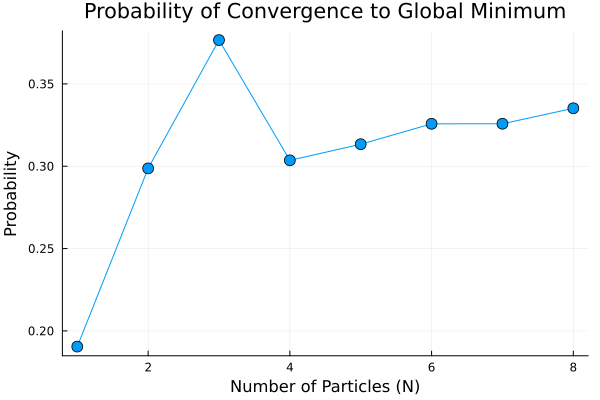

In [20]:
# Define the number of particles and corresponding convergence probabilities
num_particles = [1, 2, 3, 4, 5, 6, 7, 8]
convergence_probabilities = [0.19047619047619047, 0.2987012987012987, 0.37662337662337664, 0.3035949557688688, 
                            0.313382269904009, 0.3257655388090171, 0.32579079535601274, 0.3352065004238917]

# Create the plot
plot(num_particles, convergence_probabilities, marker = :circle, markersize = 6,
     xlabel = "Number of Particles (N)", ylabel = "Probability",
     title = "Probability of Convergence to Global Minimum",
     legend = false)

In [21]:
A = Array{Vector{Float64}}(undef, 10)
A[1] = [1, 2]
A

10-element Vector{Vector{Float64}}:
    [1.0, 2.0]
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef

### Uniform sampling

In [22]:
function is_vector_of_vectors(x)
    if typeof(x) <: Array
        for element in x
            if typeof(element) <: Array
                return true
            else
                return false
            end
        end
    else
        return false
    end
end

function ensure_vector(x)
    return (typeof(x) <: Array) ? x : [x]
end
function is_matrix(x)
    return x isa Array{<:Any,2}
end

# scalar = 5
# vector = ensure_vector(scalar)  # This will return [5]

# vector_input = [1, 2, 3]
# vector_output = ensure_vector(vector_input)  # This will return [1, 2, 3]


struct ExpResult1
    prob
    positive_mask
    average_loss
    initial_values
end


"""
X_list_iterator
grad_f(dX, X, p, t)
optimum
tol
verbose
    
Return:
    Probability of convergence to "optimum"

"""
function check_optim_for_sol(X_end, optimum, tol)
    norm(mean(X_end) - optimum) < tol
end


function one_experiment(V, grad_f, sample_dataset, exp_size::Int64, optimum, tspan=(0,100), tol=0.1; verbose=true, independent=false)        
    # Create a progress bar
    verbose && (progress_bar = Progress(exp_size, false))
    
    count = Atomic{Int64}(0)
    loss = Atomic{Float64}(0)
    positive_mask = Array{Bool}(undef, exp_size)
    initial_values = Array{Vector{Float64}}(undef, exp_size)
    
    fill!(positive_mask, 0)
    
    for i in 1:exp_size
        # X_sampler gives a list of coordinates (coordinate could either be a scalar or a vector)
        X0 = sample_dataset[i]
        # initial_values[i] = X0
        
        # Run the solver
        flag_optim = false
        
        # This is the PEDS result
        if !independent
            if is_vector_of_vectors(X0)
               X0 = transpose(stack(X0))
            end
            
            # 
            
            prob = ODEProblem(grad_f, X0, tspan)
            sol = solve(prob, Rosenbrock23(), verbose=true)
            
            X_end = sol.u[end]
            if is_matrix(X_end)
                X_end = [X_end[i, :] for i in 1:size(X_end)[1]]
            end
            
            if check_optim_for_sol(X_end, optimum, tol)
                flag_optim = true
            end
            
            atomic_add!(loss, mean(V.(X_end)))
        
        # This simulates to the restart result
        else
            min_loss = 1e3 # assuming loss is smaller than 1000
            for X00 in X0
                # Ensure it is a vector
                # X00 = ensure_vector(X00)
                if typeof(X00) <: Array
                   X00 = reshape(X00, 1, :)
                else
                    X00 = [X00]
                end
                
                # println(X00, typeof(X00))
                
                prob = ODEProblem(grad_f, X00, tspan)
                sol = solve(prob, Rosenbrock23(), verbose=true)

                X_end = sol.u[end]
                

                if is_matrix(X_end)
                    X_end = vec(X_end)
                else
                    X_end = X_end[1]
                end
                
                if norm(X_end - optimum) < tol
                    flag_optim = true
                end
                
                # Take the minimum of all losses
                min_loss = min(min_loss, mean(V(X_end)))

            end
            atomic_add!(loss, min_loss)
        end
        
        # Count the number of success
        if flag_optim
            atomic_add!(count,1)
            positive_mask[i] = 1 # Set the mask to be 1
        end
        
        verbose && next!(progress_bar)
    end
    
    # Calculate statistics)
    prob = count[] / exp_size
    average_loss = loss[] / exp_size

    
    ExpResult1(prob, positive_mask, average_loss, initial_values)
end


one_experiment (generic function with 3 methods)

In [23]:
printMsg("Running uniformly sampled experiment")

N_results = []
indep_N_results = []
dataset = []

if IN_SCRIPT
    upper = 20
    sample_size = Int(1e5)
else
    upper = 3
    sample_size = Int(1e4)
end

range_l, range_r = -2.5, 2.5

println("The total number of sample: ", sample_size)


for N=1:upper
    # Get the sampler
    # unif_sampler = collect(UniformSampler(N, range_l, range_r, sample_size))
    unif_sampler = () -> N_dim_sampler(N, () -> getRandRange(range_r, range_l, rand()))
    unif_sampled_dataset = [unif_sampler() for _ in 1:sample_size]
    
    # Experiments
    exp_res = one_experiment(V, grad_f, unif_sampled_dataset, sample_size, -1.89, verbose=false)
    push!(N_results, exp_res)
    
    exp_res = one_experiment(V, grad_f, unif_sampled_dataset, sample_size, -1.89, independent=true, verbose=false)
    push!(indep_N_results, exp_res)
    
    push!(dataset, unif_sampled_dataset)
    
    flush(stdout)
    print(".")
end
println("\nFinished")
# println("N_results: ", N_results)
# println("Indep_N_results: ", indep_N_results)

Running uniformly sampled experiment
The total number of sample: 10000
...
Finished


Experiment results
Probability to global convergence:
PEDS: 	[0.2192, 0.3873, 0.4893]
Indep: 	[0.2192, 0.3904, 0.5365]
Loss:
PEDS: 	[3.6518450168343777, 3.0600532856839067, 2.244148243300196]
Indep: 	[3.6518450168343777, 2.159334410087719, 1.4055714022030072]


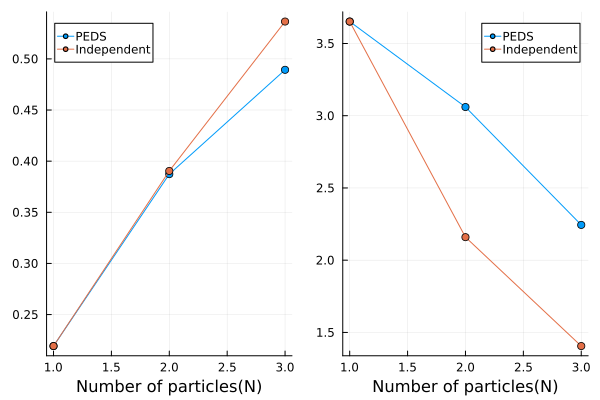

In [24]:
# prob::AbstractFloat
# positive_mask::Vector{Bool}
# average_loss::AbstractFloat
function plot_experiment_result(result1, result2)
    prob1 = [i.prob for i in result1]
    loss1 = [i.average_loss for i in result1]
    
    prob2 = [i.prob for i in result2]
    loss2 = [i.average_loss for i in result2]
    
    printMsg("Experiment results")
    println("Probability to global convergence:")
    println("PEDS: \t", prob1)
    println("Indep: \t", prob2)
    
    println("Loss:")
    println("PEDS: \t", loss1)
    println("Indep: \t", loss2)
    
    
    plot(prob1, label="PEDS", marker=:circle,)
    p1 = plot!(prob2, label="Independent", marker=:circle, xlabel="Number of particles(N)")

    plot(loss1, label="PEDS", marker=:circle)
    p2 = plot!(loss2, label="Independent", marker=:circle, xlabel="Number of particles(N)")
    
    plot(p1, p2)
end

plot_experiment_result(N_results, indep_N_results)


##### Analysis

Specifically pick up some success modes and failure modes to better understand the methods.

Number of extra fails:175
Failure mode


[ Info: Saved animation to /Users/charliechen/workspace/am_sure/failure_mode.gif


Plots.AnimatedGif("/Users/charliechen/workspace/am_sure/failure_mode.gif")
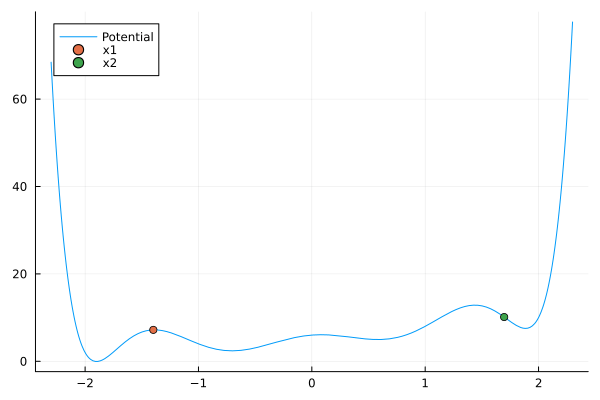

In [25]:
PEDS_mask = N_results[2].positive_mask
indep_mask = indep_N_results[2].positive_mask

initials = dataset[2]

extra_fails = (1 .- PEDS_mask) .* indep_mask

println("Number of extra fails:", sum(extra_fails))

fail_index = findall(x->x==1, extra_fails)

prob = ODEProblem(grad_f, initials[rand(fail_index)], (0,100))
sol = solve(prob, Rosenbrock23())

Plot1D(sol, V)
anim = PlotAnim1D(sol, V)

println("Failure mode")
gif(anim, "failure_mode.gif")



Number of extra sucess:144


[ Info: Saved animation to /Users/charliechen/workspace/am_sure/success_mode.gif


Plots.AnimatedGif("/Users/charliechen/workspace/am_sure/success_mode.gif")
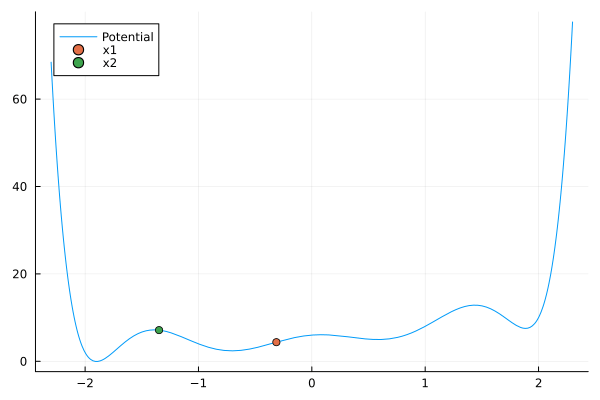

In [26]:
extra_succ = (1 .- indep_mask) .* PEDS_mask
println("Number of extra sucess:", sum(extra_succ))

succ_index = findall(x->x==1, extra_succ)

prob = ODEProblem(grad_f, initials[rand(succ_index)], (0,100))
sol = solve(prob, Rosenbrock23())

anim = PlotAnim1D(sol, V)

gif(anim, "success_mode.gif")



In [27]:
# # Indepentdent results
# #plot(N_results, label="PEDS", marker=:circle, markersize=6, xlabel="Number of particles (N)", 
#     title="Probability of convergence to global min with 1e4 samples")
# plot!(indep_N_results, label="Independent results", marker=:circle, markersize=6)

Result is 

The sample size is 1e4

0.186, 0.3015, 0.384, 0.3244, 0.3376, 0.3544, 0.3582, 0.3747, 0.3791, 0.3955, 0.4093, 0.42, 0.4382, 0.443, 0.4569, 0.4667, 0.4675, 0.4843, 0.5066, 0.5099

Sample size 1e5

0.18913, 0.30496, 0.38978, 0.3198, 0.33514, 0.35304, 0.36242, 0.37046, 0.3859, 0.40086, 0.41116, 0.4261, 0.43462, 0.44551, 0.45521, 0.46302, 0.47914, 0.48901, 0.498, 0.50454

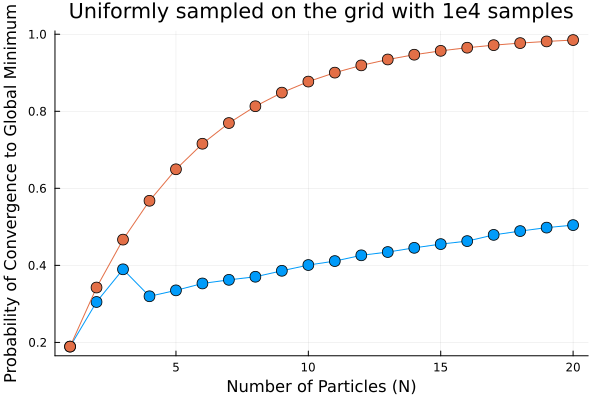

In [28]:
# Define the number of particles and corresponding convergence probabilities
convergence_probabilities = [0.18913, 0.30496, 0.38978, 0.3198, 0.33514, 0.35304, 0.36242, 0.37046, 0.3859, 0.40086, 0.41116, 0.4261, 0.43462, 0.44551, 0.45521, 0.46302, 0.47914, 0.48901, 0.498, 0.50454]
num_particles = collect(1:length(convergence_probabilities))

scaled = [1 - (1-convergence_probabilities[1])^i for i in num_particles]

# Create the plot
plot(num_particles, convergence_probabilities, marker = :circle, markersize = 6,
     xlabel = "Number of Particles (N)", ylabel = "Probability of Convergence to Global Minimum",
     title = "Uniformly sampled on the grid with 1e4 samples",
     legend = false)

plot!(num_particles, scaled, marker = :circle, markersize = 6)

## Vector function (m = 2)

We will focus on m=2 first

We will do mixture of Gaussians and classical XY model

Let's first plot some functions.



In [29]:
one_grid = -2:0.2:2

-2.0:0.2:2.0

### Gaussian

In [30]:
# Expect Sigma to be diagonal
Gaussian(X, mu, Sigma) = -1 / sqrt((2*pi)^length(X) * det(Sigma)) * exp(-1/2 * (X-mu)' * inv(Sigma) * (X-mu))
Gaussian_grad(X, mu, Sigma) = -Gaussian(X, mu, Sigma) * inv(Sigma) * (X-mu)

Gaussian_grad (generic function with 1 method)

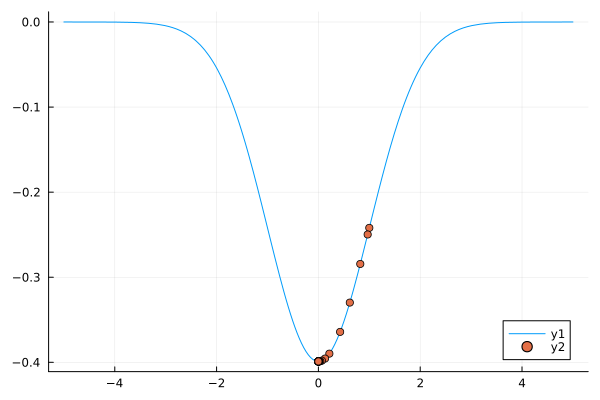

In [31]:
g1 = x -> Gaussian(x, 0, 1)
g2 = x -> Gaussian_grad(x, 0, 1)

grad_g = (u, p, t) -> -g2(u)

prob = ODEProblem(grad_g, 1, tspan)
sol = solve(prob)
# display(sol)

plot(g1)
scatter!(sol.u, g1.(sol.u))

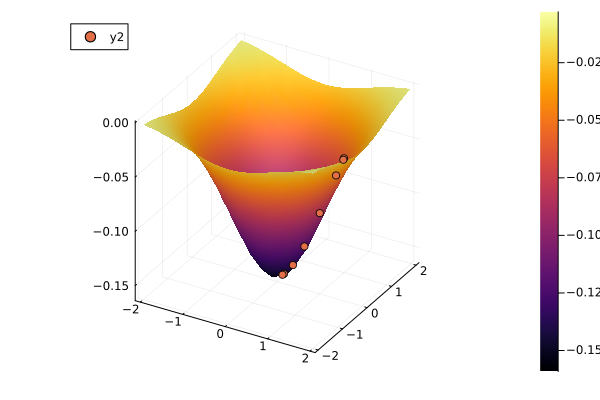

In [32]:
mu = [0,0]
Sigma = Diagonal([1,1])
g1 = X -> Gaussian(X, mu, Sigma)
# g22 = X -> ForwardDiff.gradient(g1, X)
g2 = X -> Gaussian_grad(X, mu, Sigma)
g3 = (x,y) -> g1([x,y])

grad_g = (U, p, t) -> -g2(U)

prob = ODEProblem(grad_g, [1, 1], (0,20))
sol = solve(prob)

surface(one_grid, one_grid, g3)

xs = [i[1] for i in sol.u]
ys = [i[2] for i in sol.u]

zs = g1.(sol.u)

scatter!(xs, ys, zs)

### Mixture of Gaussians

In [33]:
N = 2
mu1 = [-2,0]
mu2 = [2,0]

Sigma1, Sigma2 = Diagonal([2,1]), Diagonal([1,1])

gm1 = X -> (Gaussian(X, mu1, Sigma1) + Gaussian(X, mu2, Sigma2))
gm2 = X -> -(Gaussian_grad(X, mu1, Sigma1) + Gaussian_grad(X, mu2, Sigma2)) #f = -dV/dx
gm3 = (x,y) -> gm1([x,y])
gm4 = (x,y) -> gm2([x,y])

#74 (generic function with 1 method)

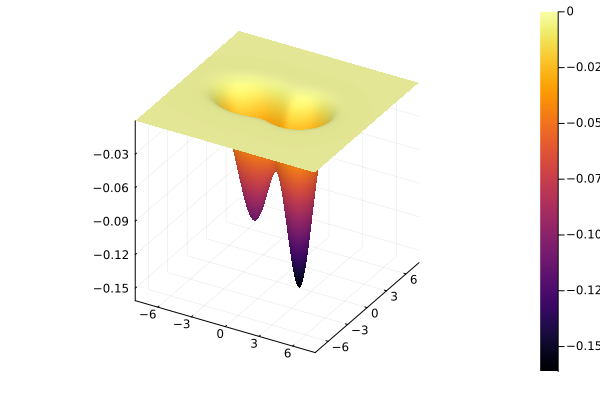

In [34]:
one_grid_large = -8:0.1:8
surface(one_grid_large, one_grid_large, gm3)

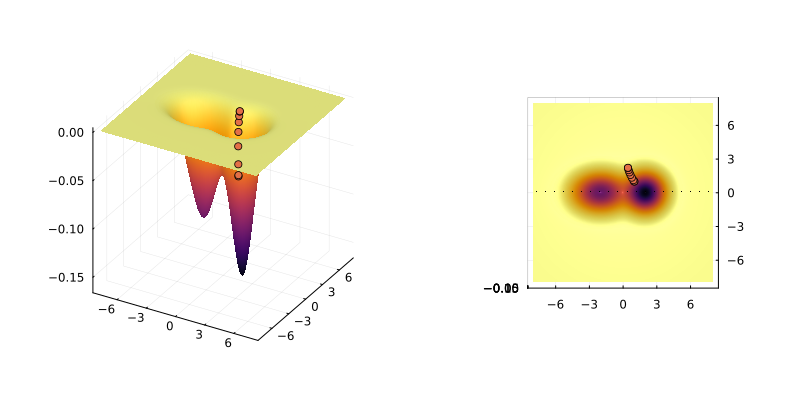

In [35]:
grad_g = (U, p, t) -> -gm2(U)

prob = ODEProblem(grad_g, [1, 1], (0,40))
sol = solve(prob)

surface(one_grid_large, one_grid_large, gm3, legend=false)

xs = [i[1] for i in sol.u]
ys = [i[2] for i in sol.u]

zs = gm1.(sol.u)

p1 = deepcopy(scatter!(xs, ys, zs))
p2 = plot!(camera=(0,90))

plot(p1, p2, layout=(1,2), size = (800,400))

##### Generic PEDS function

In [36]:
# grad_g = VectorGenerateF(X -> -gm2(X), 0.1)
grad_g = (dX, X, p=0, t=0) -> PEDS_f(dX, X, gm2, 1)

X0 = [-2.3 1; 2 -1; 2.5 1.5]
# X0 = [-2.3 1; -2 -1; 2.5 1.5]
# X0 = rand(3, 2)
# X0 = [2 -1;]
prob = ODEProblem(grad_g, X0, (0,100))
sol = solve(prob) # vector of matrix. T * [N * m]
println()

In [37]:
function matVec2Arr(mv)
    a = zeros(size(mv[1])..., length(mv))
    for i in 1:length(mv)
        a[:,:,i] = mv[i]
    end
    return a
end

sols = matVec2Arr(sol.u)
sols = permutedims(sols, (1, 3, 2))

_, T, _ = size(sols) # m, Timestamp, Dimension of the original problem

(3, 42, 2)

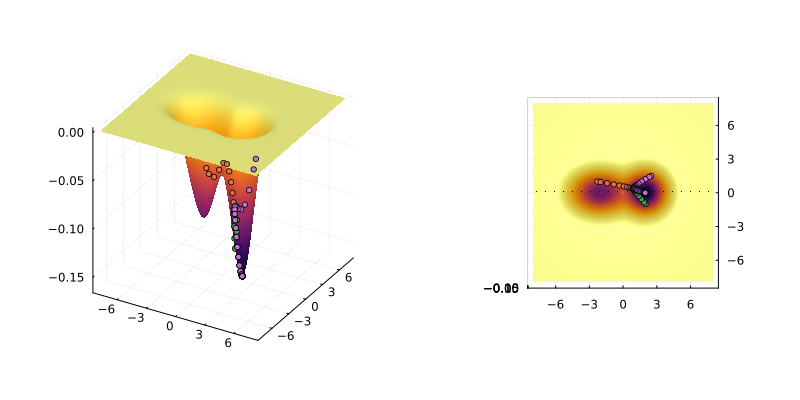

In [38]:
# Static version
surface(one_grid_large, one_grid_large, gm3, legend=false, size=(800,800))

N, m = size(X0)

for ind in 1:size(sols)[1]
    xs = [sols[ind,t,1] for t in 1:size(sols)[2]]
    ys = [sols[ind,t,2] for t in 1:size(sols)[2]]
    # println(ys)
    zs = gm3.(xs, ys)
    scatter!(xs,ys,zs, label="particle$ind", markersize=3)
end
plot!()
# zs = gm1.(sol.u)

p1 = deepcopy(plot!())
p2 = plot!(camera=(0,90))

plot(p1, p2, layout=(1,2), size = (800,400))

[ Info: Saved animation to /Users/charliechen/workspace/am_sure/Mixture_of_gaussian.gif


Plots.AnimatedGif("/Users/charliechen/workspace/am_sure/Mixture_of_gaussian.gif")
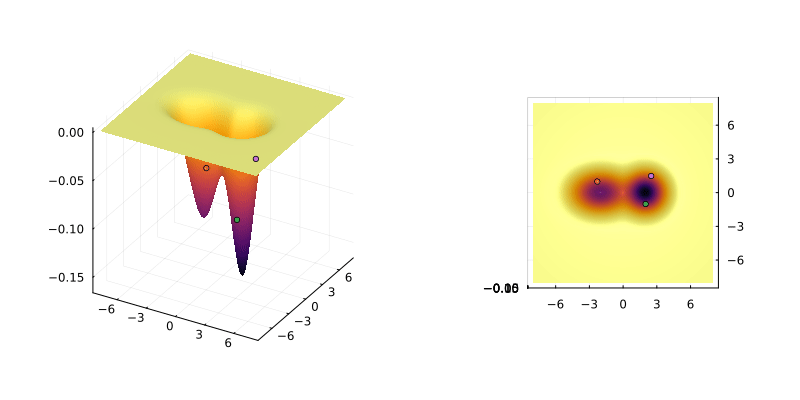

In [39]:
# Gif
N, m = size(X0)
anim = @animate for t in 1:T
    surface(one_grid_large, one_grid_large, gm3, legend=false)

    for ind in 1:size(sols)[1]
        xs = [sols[ind,t,1]]
        ys = [sols[ind,t,2]]
        # println(ys)
        zs = gm3.(xs, ys)
        scatter!(xs,ys,zs, label="particle$ind", markersize=3)
    end
    plot!()
    # zs = gm1.(sol.u)

    p1 = deepcopy(plot!())
    p2 = plot!(camera=(0,90.1))

    plot(p1, p2, layout=(1,2), size = (800,400))
end

gif(anim, "Mixture_of_gaussian.gif", fps=5)

In [40]:
transpose([1 2; 3 4])

2×2 transpose(::Matrix{Int64}) with eltype Int64:
 1  3
 2  4

In [41]:
function is_vector_of_vectors(x)
    if typeof(x) <: Array
        for element in x
            if typeof(element) <: Array
                return true
            else
                return false
            end
        end
    else
        return false
    end
end
A= ([[1,2], [3,4]])
is_vector_of_vectors(A)

true

### Experiments

In [42]:
N_results = []
indep_N_results = []

if IN_SCRIPT
    upper = 20
    sample_size = Int(1e5)
else
    upper = 3
    sample_size = Int(1e4)
end

range_l, range_r = -2.5, 2.5

println("The total number of sample: ", sample_size)


for N=1:upper
    # Get the sampler
    # unif_sampler = collect(UniformSampler(N, range_l, range_r, sample_size))
    unif_sampler = () -> N_dim_sampler(N, () -> getRandRange(range_r, range_l, rand(2)))
    unif_sampled_dataset = [unif_sampler() for _ in 1:sample_size]
    
    # Experiments
    exp_res = one_experiment(gm1, grad_g, unif_sampled_dataset, sample_size, [2, 0], verbose=false)
    push!(N_results, exp_res)
    
    exp_res = one_experiment(gm1, grad_g, unif_sampled_dataset, sample_size, [2, 0], independent=true, verbose=false)
    push!(indep_N_results, exp_res)
    
    flush(stdout)
    print(".")
end
println("\nFinished")
# println("N_results: ", N_results)
# println("Indep_N_results: ", indep_N_results)

The total number of sample: 10000
...
Finished


Experiment results
Probability to global convergence:
PEDS: 	[0.4939, 0.5091, 0.5112]
Indep: 	[0.4939, 0.7488, 0.8785]
Loss:
PEDS: 	[-0.1365503994526774, -0.13737161933874992, -0.1374395577822245]
Indep: 	[-0.1365503994526774, -0.1491583287463196, -0.1554189464862739]


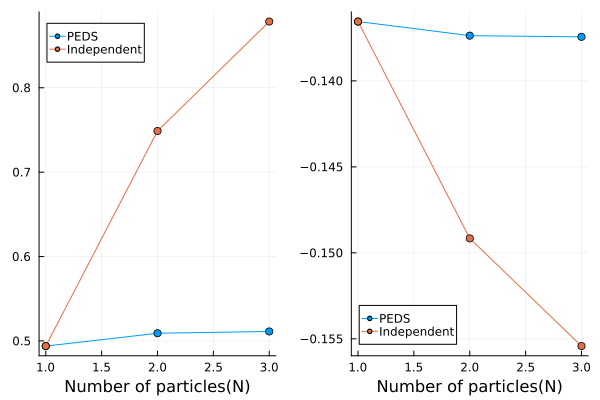

In [43]:
plot_experiment_result(N_results, indep_N_results)
